${\huge \textbf{Part 1 - Dataset Notes}}$:

${\scriptsize \textbf{1.1 Data Assets}}$

$\hspace{3em} {\scriptsize \textbf{1.10 Descriptions of Active Assets (Report)}}$

$\hspace{3em} {\scriptsize \textbf{1.11 Discussion of Future Assets (Report)}}$

${\scriptsize \textbf{1.2 Downloading Datasets}}$

$\hspace{3em} {\scriptsize \textbf{1.20 General Procedure (Report)}}$

$\hspace{3em} {\scriptsize \textbf{1.21 FPDS Procedure (Not in Report)}}$

$\hspace{3em} {\scriptsize \textbf{1.22 USASpending Procedure (Not in Report)}}$

$\hspace{3em} {\scriptsize \textbf{1.23 Intermediary Processing Steps (Not in Report)}}$

${\scriptsize \textbf{1.3 Dataset Higher Level Analysis}}$

$\hspace{3em} {\scriptsize \textbf{1.30 }}$

$\hspace{3em} {\scriptsize \textbf{1.31 Feature Descriptions}}$

---

${\normalsize \textbf{1.1 Data Assets}}$

---

${\small \textbf{1.10 Descriptions of Active Assets}}$

---

${\small \textbf{1.11 Discussion of Future Assets}}$

---

${\normalsize \textbf{1.2 Downloading Datasets}}$

---

${\small \textbf{1.21 FPDS Procedure}}$

---

${\small \textbf{1.22 USASpending Procedure}}$

---

${\small \textbf{1.23 Intermediary Processing Steps}}$

---

 - Part 1 Grounds for Contract Removal from Data
     - being an amendment to the original contract
     
     
 - Special Contract Types
     - if total corresponding action obligation is deobligated (to 0) with subsequent modifications to original
     - FAR 6.302 (Circumstances enabling non full competititive practices): will need to write some regex to check 
       'Competitive Procedures / Other Than Full And Open Competition' box)
         - 6.302-1 Only one responsible source and no other supplies or services will satisfy agency requirements.
         - 6.302-2 Unusual and compelling urgency.
         - 6.302-3 Industrial mobilization; engineering, developmental, or research capability; or expert services.
         - 6.302-4 International agreement.
         - 6.302-5 Authorized or required by statute.
         - 6.302-6 National security.
         - 6.302-7 Public interest.
     - FAR 18 (Emergency Acquisitions), will need regex to check
     - *SBA designated contracts
         - 8(a) Business Development program
         - HUBZone program
         - Women-Owned Small Business program
         - Service-Disabled Veteran-Owned Small Business program
     - When entity location components are empty (e.g. Environmental Assessment and REM)
         - (already made the check to see if other contracts with the same entity name have this information)
        

 - $\textbf{Retained Features}$
     - General
         - Contract ID (str) $\textbf{[Feature 1]}$
         - Action Obligation (float) $\textbf{[Feature 2]}$
         - Date Signed (datetime) $\textbf{[Feature 3]}$
         - PSC (str) $\textbf{[Feature 3]}$
         - Entity Location (Transform City and State to General Location) (str) $\textbf{[Feature 4]}$
         - Government Agency (str) $\textbf{[Feature 5]}$
         - Ultimate Parent Unique Entity ID: (str) $\textbf{[Feature 6]}$
     - Specific
         - Competitin Type (0 for open, 1 for special circumstances e.g. FAR 6.302 contracts) $\textbf{[Feature 7]}$
         - Number of Offers Received $\textbf{[Feature 8]}$
         - Principal Place of Performance $\textbf{[Feature 9]}$

### Imports

In [2]:
from tqdm import tqdm
import math
import time
import warnings
warnings.filterwarnings("ignore")
import time
import os
import polars as pl
import us
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

### File Directory Setup

In [3]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'Data')
data_folder = [os.path.join(data_dir, i) for i in os.listdir(data_dir)]

### Removing Duplicates

In [4]:
samp_df = pl.read_csv(data_folder[0])
df_dict = {str(year): pl.DataFrame(schema={col: pl.Utf8 for col in samp_df.columns}) for year in range(2000, 2025)}

for interval in data_folder:
    year = interval[67:71]
    dtypes = {col: pl.Utf8 for col in samp_df.columns}
    cur_df = pl.read_csv(interval,dtypes = dtypes, encoding="utf8-lossy")
    cur_df = cur_df.filter(cur_df["Modification Number"] == "0")
    df_dict[year] = df_dict[year].vstack(cur_df)
    
df_dict["2000"].head()

Contract ID,Reference IDV,Modification Number,Transaction Number,Award/IDV Type,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,NAICS Description,Entity City,Entity State,Entity ZIP Code,Additional Reporting Code,Additional Reporting Description,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Legal Business Name,CAGE Code,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0036CC10252""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,184,112.00""","""Mar 7, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""EL DORADO""",null,null,null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""construcciones electronmecanic…",null,null
"""V0010F200006DV101BC0180""",null,"""0""","""0""","""DCA Definitive Contract""","""$0.00""","""Jun 15, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROOKSVILLE""","""FL""","""346028213""",null,null,"""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""CASCADE MECHANICAL INCORPORATE…",null,null
"""0036CC10543""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,003,227.00""","""Sep 5, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""UPPER MARLBORO""","""MD""","""207742456""",null,null,"""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED""","""K LO CONSTRUCTION INCORPORATED""",null,null
"""V623C723""",null,"""0""","""0""","""DCA Definitive Contract""","""$57,920.00""","""Sep 7, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROKEN ARROW""","""OK""","""740144811""",null,null,"""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC""","""C3 LIMITED LIABILITY COMPANY""",null,null


In [111]:
regions

['West',
 'Southeast',
 'Southeast',
 'Southwest',
 'Southwest',
 'Southeast',
 'Southeast',
 'Southeast',
 'Southwest',
 'Northeast',
 'Northeast',
 'Southeast',
 'Northeast',
 'Southeast',
 'Southeast',
 'Midwest',
 'Southeast',
 'Southeast',
 'Southeast',
 'Midwest',
 'Southeast',
 'Southeast',
 'Southeast',
 'West',
 'Northeast',
 'Southeast',
 'Southeast',
 'West',
 'Southeast',
 'Midwest',
 'Unknown',
 'Unknown',
 'West',
 'Midwest',
 'Southeast',
 'West',
 'Northeast',
 'Unknown',
 'Unknown',
 'Unknown',
 'Southeast',
 'Unknown',
 'West',
 'Southeast',
 'Unknown',
 'Southeast',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Midwest',
 'Southwest',
 'Southeast',
 'Southeast',
 'Unknown',
 'Southeast',
 'West',
 'Unknown',
 'Southeast',
 'Unknown',
 'Southwest',
 'Midwest',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Southeast',
 'Southeast',
 'Southeast',
 'Southeast',
 'Southwest',
 'Southeast',
 'Southeast',
 'Unknown',
 'Southeast',
 'Northeast',
 'Southwe

In [6]:
combined_df = pl.DataFrame(schema={col: pl.Utf8 for col in samp_df.columns})
for key in df_dict:
    combined_df = combined_df.vstack(df_dict[key])

combined_df = combined_df.unique(maintain_order=True)
print(f'Total Entries: {combined_df.shape[0]}')
combined_df.head()

Total Entries: 56442


Contract ID,Reference IDV,Modification Number,Transaction Number,Award/IDV Type,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,NAICS Description,Entity City,Entity State,Entity ZIP Code,Additional Reporting Code,Additional Reporting Description,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Legal Business Name,CAGE Code,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0036CC10252""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,184,112.00""","""Mar 7, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""EL DORADO""",null,null,null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""construcciones electronmecanic…",null,null
"""V0010F200006DV101BC0180""",null,"""0""","""0""","""DCA Definitive Contract""","""$0.00""","""Jun 15, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROOKSVILLE""","""FL""","""346028213""",null,null,"""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""CASCADE MECHANICAL INCORPORATE…",null,null
"""0036CC10543""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,003,227.00""","""Sep 5, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""UPPER MARLBORO""","""MD""","""207742456""",null,null,"""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED""","""K LO CONSTRUCTION INCORPORATED""",null,null
"""V623C723""",null,"""0""","""0""","""DCA Definitive Contract""","""$57,920.00""","""Sep 7, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROKEN ARROW""","""OK""","""740144811""",null,null,"""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC""","""C3 LIMITED LIABILITY COMPANY""",null,null
"""INICMH00010011""",null,"""0""","""0""","""DCA Definitive Contract""","""$195,500.00""","""Mar 19, 2001""",null,"""1450""","""BUREAU OF INDIAN AFFAIRS""","""WESTERN REGIONAL OFFICE""","""S""","""Z166""","""MAINT-REP-ALT/PENAL FACILITIES""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""TUCSON""","""AZ""","""857196742""",null,null,"""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC.""","""M G M ASSOCIATES INCORPORATED""",null,null


### Processing - (Remove Unnecessary Columns)

In [7]:
drop_columns = ['Reference IDV', 
                'Modification Number', 
                'Award/IDV Type', 
                'NAICS Description', 
                'Additional Reporting Code', 
                'Additional Reporting Description',
                'CAGE Code',
                'Transaction Number',
                'Legal Business Name',
                '']

combined_df = combined_df.drop(drop_columns)

### Processing - (Modifying Specific Columns)

In [8]:
combined_df.head()

Contract ID,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,Entity City,Entity State,Entity ZIP Code,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0036CC10252""","""$1,184,112.00""","""Mar 7, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""EL DORADO""",null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…"
"""V0010F200006DV101BC0180""","""$0.00""","""Jun 15, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""","""236220""","""BROOKSVILLE""","""FL""","""346028213""","""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…"
"""0036CC10543""","""$1,003,227.00""","""Sep 5, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""UPPER MARLBORO""","""MD""","""207742456""","""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED"""
"""V623C723""","""$57,920.00""","""Sep 7, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…","""236220""","""BROKEN ARROW""","""OK""","""740144811""","""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC"""
"""INICMH00010011""","""$195,500.00""","""Mar 19, 2001""",null,"""1450""","""BUREAU OF INDIAN AFFAIRS""","""WESTERN REGIONAL OFFICE""","""S""","""Z166""","""MAINT-REP-ALT/PENAL FACILITIES""","""236220""","""TUCSON""","""AZ""","""857196742""","""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC."""


In [9]:
# action obligation changing
combined_df = combined_df.with_columns(
    pl.col("Action Obligation ($)")
    .str.replace_all(r"[\$,]", "")
    .str.replace_all(r"\..*", "")
    .str.strip_chars()
    .cast(pl.Int64)
)

# dates
combined_df = combined_df.with_columns(
    pl.col("Date Signed").str.strptime(pl.Date, "%b %d, %Y", strict=False),
    pl.col("Solicitation Date").str.strptime(pl.Date, "%b %d, %Y", strict=False)
)

# changing NAICS to int
combined_df = combined_df.with_columns(
    pl.col("NAICS").cast(pl.Int64)
)

combined_df.head()

Contract ID,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,Entity City,Entity State,Entity ZIP Code,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name
str,i64,date,date,str,str,str,str,str,str,i64,str,str,str,str,str,str
"""0036CC10252""",1184112,2000-03-07,null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…",236220,"""EL DORADO""",null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…"
"""V0010F200006DV101BC0180""",0,2000-06-15,null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""",236220,"""BROOKSVILLE""","""FL""","""346028213""","""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…"
"""0036CC10543""",1003227,2000-09-05,null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…",236220,"""UPPER MARLBORO""","""MD""","""207742456""","""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED"""
"""V623C723""",57920,2000-09-07,null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…",236220,"""BROKEN ARROW""","""OK""","""740144811""","""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC"""
"""INICMH00010011""",195500,2001-03-19,null,"""1450""","""BUREAU OF INDIAN AFFAIRS""","""WESTERN REGIONAL OFFICE""","""S""","""Z166""","""MAINT-REP-ALT/PENAL FACILITIES""",236220,"""TUCSON""","""AZ""","""857196742""","""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC."""


In [10]:
import polars as pl

state_to_region = {
    "ME": "Northeast", "NH": "Northeast", "VT": "Northeast", "MA": "Northeast",
    "RI": "Northeast", "CT": "Northeast", "NY": "Northeast", "NJ": "Northeast",
    "PA": "Northeast", "DE": "Southeast", "MD": "Southeast", "VA": "Southeast",
    "WV": "Southeast", "KY": "Southeast", "NC": "Southeast", "SC": "Southeast",
    "TN": "Southeast", "GA": "Southeast", "FL": "Southeast", "AL": "Southeast",
    "DC": "Southeast", "MS": "Southeast", "LA": "Southeast", "AR": "Southeast", 
    "MO": "Midwest", "OH": "Midwest", "IN": "Midwest", "IL": "Midwest", "MI": "Midwest",
    "WI": "Midwest", "MN": "Midwest", "IA": "Midwest", "ND": "Midwest",
    "SD": "Midwest", "NE": "Midwest", "KS": "Midwest", "MT": "West",
    "ID": "West", "WY": "West", "CO": "West", "UT": "West", "NV": "West",
    "CA": "West", "OR": "West", "WA": "West", "AK": "West", "HI": "West",
    "TX": "Southwest", "OK": "Southwest", "NM": "Southwest", "AZ": "Southwest"
}

def get_state_from_zip(zip_code):
    geolocator = Nominatim(user_agent="geocoding_app")
    location = geolocator.geocode(zip_code, addressdetails=True)
    
    if location and location.raw.get('address'):
        address_data = location.raw['address']
        state = address_data.get('state') or address_data.get('province')
        return state
    else:
        return None
    
def get_state_from_city(city_name):
    geolocator = Nominatim(user_agent="geocoding_app")
    location = geolocator.geocode(city_name, addressdetails=True)
    
    if location and location.raw.get('address'):
        address_data = location.raw['address']
        state = address_data.get('state') or address_data.get('province')
        return state
    else:
        return None
    
def get_state_abbreviation(state_name: str):
    """Convert full state name to abbreviation (e.g., 'California' -> 'CA')."""
    state = us.states.lookup(state_name)
    return state.abbr if state else None

def assign_region(row_city, row_state, row_zip_code):
    state = None
    
    if row_state:
        if row_state not in state_to_region.keys():
            return "Unknown"
        return state_to_region[row_state]
    
    if row_city and not row_zip_code:
        state = get_state_from_city(row_city)
    if row_zip_code and not row_city:
        state = get_state_from_zip(row_zip_code)

    if state:
        time.sleep(0.5)
        state_abr = get_state_abbreviation(state)
        if state_abr in state_to_region:
            return state_to_region[state_abr]
    return "Unknown"

In [11]:
regions = []

for row in tqdm(combined_df.iter_rows(), total=combined_df.height, desc="Processing rows"):
    city = row[11]
    state = row[12]
    zip_code = row[13]
    region = assign_region(city, state, zip_code)
    regions.append(region)

regions[:10]

Processing rows: 100%|███████████████████████████████████████████████████████████| 56442/56442 [10:42<00:00, 87.83it/s]


['West',
 'Southeast',
 'Southeast',
 'Southwest',
 'Southwest',
 'Southeast',
 'Southeast',
 'Southeast',
 'Southwest',
 'Northeast']

In [12]:
combined_df = combined_df.with_columns(
    pl.Series("Region", regions)
)

combined_df = combined_df.filter(combined_df["Region"] != "Unknown")

combined_df.head()

Contract ID,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,Entity City,Entity State,Entity ZIP Code,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Region
str,i64,date,date,str,str,str,str,str,str,i64,str,str,str,str,str,str,str
"""0036CC10252""",1184112,2000-03-07,null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…",236220,"""EL DORADO""",null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""West"""
"""V0010F200006DV101BC0180""",0,2000-06-15,null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""",236220,"""BROOKSVILLE""","""FL""","""346028213""","""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""Southeast"""
"""0036CC10543""",1003227,2000-09-05,null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…",236220,"""UPPER MARLBORO""","""MD""","""207742456""","""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED""","""Southeast"""
"""V623C723""",57920,2000-09-07,null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…",236220,"""BROKEN ARROW""","""OK""","""740144811""","""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC""","""Southwest"""
"""INICMH00010011""",195500,2001-03-19,null,"""1450""","""BUREAU OF INDIAN AFFAIRS""","""WESTERN REGIONAL OFFICE""","""S""","""Z166""","""MAINT-REP-ALT/PENAL FACILITIES""",236220,"""TUCSON""","""AZ""","""857196742""","""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC.""","""Southwest"""


In [115]:
import pickle

regions_dest = os.path.join(data_dir, 'regions.pkl')

with open(regions_dest, 'wb') as f:
    pickle.dump(regions, f)

In [13]:
print(f'Total Entries: {combined_df.shape[0]}')

Total Entries: 53004


In [14]:
naics_data_dir = os.path.join(cur_dir, 'NAICS Processed')
save_dir = os.path.join(naics_data_dir, '236220_init_proc.csv')
combined_df.write_csv(save_dir)

### Building Compressed Dataframe

- $\textbf{Important Columns}$:
    - Contract ID
    - Action Obligation
    - Date Signed
    - Contracting Agency ID
    - PSC
    - NAICS
    - Business Entity ID (Merge Ultimate Parent and Unique Entity)
    - Region
    
    
- $\textbf{Lesser/Redundant Columns}$:
    - Solicitation Date
    - Contracting Agency
    - Contracting Office Name
    - PSC Type
    - PSC Description
    - Entity City
    - Entity State
    - Entity ZIP Code
    - Unique Entity ID
    - Ultimate Parent Unique Entity ID
    - Ultimate Parent Legal Business Name


- Initial Column #: 18
- Compressed #: 8 

In [15]:
combined_df = combined_df.with_columns(
    pl.col("Ultimate Parent Unique Entity ID")
    .fill_null(pl.col("Unique Entity ID"))
    .alias("Business Entity ID")
)

combined_df.head()

Contract ID,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,Entity City,Entity State,Entity ZIP Code,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Region,Business Entity ID
str,i64,date,date,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str
"""0036CC10252""",1184112,2000-03-07,null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…",236220,"""EL DORADO""",null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""West""","""KPM2V2K76SB8"""
"""V0010F200006DV101BC0180""",0,2000-06-15,null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""",236220,"""BROOKSVILLE""","""FL""","""346028213""","""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""Southeast""","""EN73L9MPC129"""
"""0036CC10543""",1003227,2000-09-05,null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…",236220,"""UPPER MARLBORO""","""MD""","""207742456""","""H2XFGR46UMA1""","""H2XFGR46UMA1""","""K-LO CONSTRUCTION INCORPORATED""","""Southeast""","""H2XFGR46UMA1"""
"""V623C723""",57920,2000-09-07,null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""623-MUSKOGEE""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…",236220,"""BROKEN ARROW""","""OK""","""740144811""","""J9B5J1JFPEK3""","""J9B5J1JFPEK3""","""C3 LLC""","""Southwest""","""J9B5J1JFPEK3"""
"""INICMH00010011""",195500,2001-03-19,null,"""1450""","""BUREAU OF INDIAN AFFAIRS""","""WESTERN REGIONAL OFFICE""","""S""","""Z166""","""MAINT-REP-ALT/PENAL FACILITIES""",236220,"""TUCSON""","""AZ""","""857196742""","""GM9SKMQCH5N5""","""GM9SKMQCH5N5""","""M.G.M. ASSOCIATES INC.""","""Southwest""","""GM9SKMQCH5N5"""


In [16]:
compress_columns = ['Solicitation Date',
                    'Contracting Agency',
                    'Contracting Office Name',
                    'PSC Type',
                    'PSC Description',
                    'Entity City',
                    'Entity State',
                    'Entity ZIP Code',
                    'Unique Entity ID',
                    'Ultimate Parent Unique Entity ID',
                    'Ultimate Parent Legal Business Name']

combined_df = combined_df.drop(compress_columns)

combined_df.head()

Contract ID,Action Obligation ($),Date Signed,Contracting Agency ID,PSC,NAICS,Region,Business Entity ID
str,i64,date,str,str,i64,str,str
"""0036CC10252""",1184112,2000-03-07,"""3300""","""Z191""",236220,"""West""","""KPM2V2K76SB8"""
"""V0010F200006DV101BC0180""",0,2000-06-15,"""3600""","""Y219""",236220,"""Southeast""","""EN73L9MPC129"""
"""0036CC10543""",1003227,2000-09-05,"""3300""","""Z191""",236220,"""Southeast""","""H2XFGR46UMA1"""
"""V623C723""",57920,2000-09-07,"""3600""","""Y141""",236220,"""Southwest""","""J9B5J1JFPEK3"""
"""INICMH00010011""",195500,2001-03-19,"""1450""","""Z166""",236220,"""Southwest""","""GM9SKMQCH5N5"""


In [ ]:
combined_df

In [17]:
naics_data_dir = os.path.join(cur_dir, 'NAICS Processed')
save_dir = os.path.join(naics_data_dir, '236220_compress_proc.csv')
combined_df.write_csv(save_dir)

(array([ 158., 3770., 7364., 7443., 7501., 6953., 4127., 7153., 3104.,
        5431.]),
 array([2000. , 2002.4, 2004.8, 2007.2, 2009.6, 2012. , 2014.4, 2016.8,
        2019.2, 2021.6, 2024. ]),
 <BarContainer object of 10 artists>)

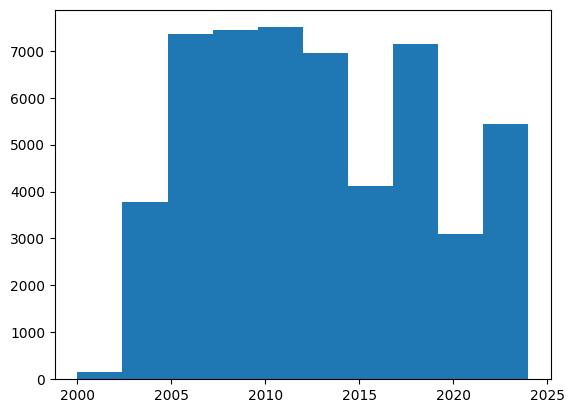

In [20]:
years = [i.year for i in list(combined_df['Date Signed'])]
plt.hist(years)

In [41]:
combined_df.filter(combined_df["Action Obligation ($)"] == 0)

Contract ID,Action Obligation ($),Date Signed,Contracting Agency ID,PSC,NAICS,Region,Business Entity ID
str,i64,date,str,str,i64,str,str
"""V0010F200006DV101BC0180""",0,2000-06-15,"""3600""","""Y219""",236220,"""Southeast""","""EN73L9MPC129"""
"""GS04P01CXC0007""",0,2002-10-01,"""4740""","""Z111""",236220,"""Southeast""","""VYBHWWZM87B3"""
"""N6246794C0710""",0,2002-10-01,"""1700""","""Y139""",236220,"""Southwest""","""LYT1J2VFCWF6"""
"""SGM50002C1157""",0,2002-09-05,"""1900""","""Y111""",236220,"""Southeast""","""LN9PU5M2YZN5"""
"""3142200106D5031421018""",0,2002-10-15,"""12B0""","""Z111""",236220,"""Southeast""","""TMF5L9J8YSQ3"""
…,…,…,…,…,…,…,…
"""15F06724C0001206""",0,2024-09-06,"""1549""","""Y1PA""",236220,"""West""","""WJMCTFMA4LR1"""
"""19AQMM24C0172""",0,2024-09-30,"""1900""","""Y1AA""",236220,"""Midwest""","""H9NTYAE2J1J3"""
"""33330224CT0010422""",0,2024-09-13,"""3300""","""Y1JA""",236220,"""Southeast""","""HZ7HBNB514J3"""


In [52]:
# combine additional obligations under one contract sum all the action obligations with one another

collated_df = combined_df.group_by("Contract ID").agg([
    pl.col("NAICS").first().alias("NAICS"),
    pl.col("Date Signed").min().alias("Date Signed"),
    pl.col("Contracting Agency ID").first().alias("Contracting Agency ID"),
    pl.col("PSC").first().alias("PSC"),
    pl.col("Region").first().alias("Region"),
    pl.col("Business Entity ID").first().alias("Business Entity ID"),
    pl.col("Action Obligation ($)").sum().alias("Action Obligation ($)"),
])

collated_df.head()


Contract ID,NAICS,Date Signed,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($)
str,i64,date,str,str,str,str,i64
"""GS11P14MAP0340""",236220,2014-10-16,"""4740""","""Z2AA""","""Southeast""","""RWDWFG6WGRK9""",644325
"""IND0407CT66810""",236220,2006-12-21,"""1406""","""Y199""","""West""","""U4K9M66MUHR9""",68450
"""W912LD06C0036""",236220,2006-09-25,"""2100""","""Y111""","""Northeast""","""EATDZJL6JFJ5""",12573650
"""GS11P06ZGC0339""",236220,2006-10-17,"""4740""","""J039""","""Southeast""","""QKCFMFL4MKT6""",11943
"""HHSD200200618928C""",236220,2006-08-30,"""7523""","""Y111""","""Midwest""","""TTHNY8N2PQR3""",192500


#### Add Modification Number

In [21]:
# getting value counts for each contract

non_proc_combined_df = pl.DataFrame(schema={col: pl.Utf8 for col in samp_df.columns})

for interval in data_folder:
    cur_df = pl.read_csv(interval,dtypes = dtypes, encoding="utf8-lossy")
    non_proc_combined_df = non_proc_combined_df.vstack(cur_df)
    
non_proc_combined_df.head()

Contract ID,Reference IDV,Modification Number,Transaction Number,Award/IDV Type,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,NAICS Description,Entity City,Entity State,Entity ZIP Code,Additional Reporting Code,Additional Reporting Description,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Legal Business Name,CAGE Code,
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""0036CC10252""",null,"""0""","""0""","""DCA Definitive Contract""","""$1,184,112.00""","""Mar 7, 2000""",null,"""3300""","""SMITHSONIAN INSTITUTION""","""SMITHSONIAN INSTITUTION""","""S""","""Z191""","""MAINT-REP-ALT/EXHIBITION BUILD…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""EL DORADO""",null,null,null,null,"""KPM2V2K76SB8""",null,"""construcciones electronmecanic…","""construcciones electronmecanic…",null,null
"""EX000200005DGS04P99EXC0014""",null,"""PSR3""","""0""","""DCA Definitive Contract""","""$48,222.00""","""May 15, 2000""",null,"""4740""","""PUBLIC BUILDINGS SERVICE""","""ACQUISITION DIVISION/NON-PROSP…","""S""","""Z111""","""MAINT-REP-ALT/OFFICE BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""MONTGOMERY""","""AL""","""361091100""",null,null,"""KJ1ZS574VV73""","""KJ1ZS574VV73""","""CADDELL CONSTRUCTION CO. INC.""","""CADDELL CONSTRUCTION COMPANY,""",null,null
"""V0010F200006DV101BC0180""",null,"""0""","""0""","""DCA Definitive Contract""","""$0.00""","""Jun 15, 2000""",null,"""3600""","""VETERANS AFFAIRS, DEPARTMENT O…","""NATIONAL CEMETERY ADMINISTRATI…","""S""","""Y219""","""CONSTRUCT/OTHER CONSERVATION""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BROOKSVILLE""","""FL""","""346028213""",null,null,"""EN73L9MPC129""","""EN73L9MPC129""","""CASCADE MECHANICAL INCORPORATE…","""CASCADE MECHANICAL INCORPORATE…",null,null
"""GS06P06GYC0017""",null,"""PC04""","""0""","""DCA Definitive Contract""","""$1,800.00""","""Jul 12, 2000""",null,"""4740""","""PUBLIC BUILDINGS SERVICE""","""GSA/PUBLIC BUILDINGS SERVICE""","""S""","""Z111""","""MAINT-REP-ALT/OFFICE BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""WEST DES MOINES""","""IA""","""502654754""",null,null,"""Q8ZEUC48K3K9""","""Q8ZEUC48K3K9""","""NUNO ELECTRIC LLC""","""NUNO ELECTRIC LIMITED LIABILIT…",null,null
"""GS06P06GYC0017""",null,"""PC06""","""0""","""DCA Definitive Contract""","""$229.90""","""Jul 12, 2000""",null,"""4740""","""PUBLIC BUILDINGS SERVICE""","""GSA/PUBLIC BUILDINGS SERVICE""","""S""","""Z111""","""MAINT-REP-ALT/OFFICE BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""WEST DES MOINES""","""IA""","""502654754""",null,null,"""Q8ZEUC48K3K9""","""Q8ZEUC48K3K9""","""NUNO ELECTRIC LLC""","""NUNO ELECTRIC LIMITED LIABILIT…",null,null


In [56]:
non_proc_combined_df = non_proc_combined_df.with_columns(
    pl.col("Action Obligation ($)")
    .str.replace_all(r"[\$,]", "")
    .str.replace_all(r"\..*", "")
    .str.strip_chars()
    .cast(pl.Int64)
)

In [90]:
modified_combined_df = non_proc_combined_df.filter(non_proc_combined_df["Modification Number"] != 0)

modified_combined_df = modified_combined_df = modified_combined_df.group_by("Contract ID").agg([
    pl.count().alias("Modification Count"),
    pl.col("Action Obligation ($)").abs().sum().alias("Total Modified Action Obligation ($)")
])

modified_combined_df.head()

Contract ID,Modification Count,Total Modified Action Obligation ($)
str,u32,i64
"""HSCGG116CPRV171""",4,476417
"""36C25621C0067""",3,90000
"""GS10P13XJC0025""",1,0
"""140P4321C0029""",3,0
"""W9123822C0023""",7,15373


In [91]:

merged_df = collated_df.join(modified_combined_df, on="Contract ID", how="left")

merged_df = merged_df.with_columns([
    pl.col("Modification Count").fill_null(0),
    pl.col("Total Modified Action Obligation ($)").fill_null(0)
])
# merged_df = merged_df["Total Modified Action Obligation ($)"]
merged_df.head()

Contract ID,NAICS,Date Signed,Contracting Agency ID,PSC,Region,Business Entity ID,Action Obligation ($),Modification Count,Total Modified Action Obligation ($)
str,i64,date,str,str,str,str,i64,u32,i64
"""GS11P14MAP0340""",236220,2014-10-16,"""4740""","""Z2AA""","""Southeast""","""RWDWFG6WGRK9""",644325,1,28426
"""IND0407CT66810""",236220,2006-12-21,"""1406""","""Y199""","""West""","""U4K9M66MUHR9""",68450,0,0
"""W912LD06C0036""",236220,2006-09-25,"""2100""","""Y111""","""Northeast""","""EATDZJL6JFJ5""",12573650,15,556384
"""GS11P06ZGC0339""",236220,2006-10-17,"""4740""","""J039""","""Southeast""","""QKCFMFL4MKT6""",11943,1,1504
"""HHSD200200618928C""",236220,2006-08-30,"""7523""","""Y111""","""Midwest""","""TTHNY8N2PQR3""",192500,1,38349


In [92]:
naics_data_dir = os.path.join(cur_dir, 'NAICS Processed')
save_dir = os.path.join(naics_data_dir, '236220_second_proc.csv')
merged_df.write_csv(save_dir)

In [101]:
non_proc_combined_df.filter(non_proc_combined_df["Contracting Agency ID"] == '2100')

Contract ID,Reference IDV,Modification Number,Transaction Number,Award/IDV Type,Action Obligation ($),Date Signed,Solicitation Date,Contracting Agency ID,Contracting Agency,Contracting Office Name,PSC Type,PSC,PSC Description,NAICS,NAICS Description,Entity City,Entity State,Entity ZIP Code,Additional Reporting Code,Additional Reporting Description,Unique Entity ID,Ultimate Parent Unique Entity ID,Ultimate Parent Legal Business Name,Legal Business Name,CAGE Code,
str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""DAHA1202C0013""",null,"""0""","""0""","""DCA Definitive Contract""",6653000,"""Dec 3, 2001""",null,"""2100""","""DEPT OF THE ARMY""","""USPFO FOR INDIANA""","""S""","""Y129""","""CONSTRUCT/OTHER AIRFIELD STRUC…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""INDIANAPOLIS""","""IN""","""46228""",null,null,"""C3QAJLG8MLN5""","""C3QAJLG8MLN5""","""GARCIA CONSTRUCTION GROUP INC""","""G M CONSTRUCTION, INC""",null,null
"""DACA8502C0004""",null,"""0""","""0""","""DCA Definitive Contract""",62096000,"""Feb 22, 2002""",null,"""2100""","""DEPT OF THE ARMY""","""USA ENGINEER DISTRICT, ALASKA""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""ANCHORAGE""","""AK""","""99503""",null,null,"""VZULGLS13E18""","""VZULGLS13E18""","""DICK PACIFIC/GHEMM JV""","""DICK PACIFIC GHEMM JV""",null,null
"""DACA8502C0004""",null,"""P00001""","""0""","""DCA Definitive Contract""",148000,"""May 2, 2002""",null,"""2100""","""DEPT OF THE ARMY""","""USA ENGINEER DISTRICT, ALASKA""","""S""","""Y141""","""CONSTRUCT/HOSPITALS & INFIRMAR…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""ANCHORAGE""","""AK""","""99503""",null,null,"""VZULGLS13E18""","""VZULGLS13E18""","""DICK PACIFIC/GHEMM JV""","""DICK PACIFIC GHEMM JV""",null,null
"""DAJA8902C4025""",null,"""0""","""0""","""DCA Definitive Contract""",19526,"""Aug 13, 2002""",null,"""2100""","""DEPT OF THE ARMY""","""RCO WUERZBURG""","""S""","""Z199""","""MAINT-REP-ALT/MISC BLDGS""","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""BONN""",null,"""53179""",null,null,"""WWFNFCV65M13""","""WWFNFCV65M13""","""BUNDESAMT FUER BAUWESEN UND RA…","""BUNDESAMT FUER BAUWESEN UND RA…",null,null
"""DACA6102C0004""",null,"""0""","""0""","""DCA Definitive Contract""",6634200,"""Oct 1, 2002""",null,"""2100""","""DEPT OF THE ARMY""","""USA ENGINEER DSTRCT, PHILADELP…","""S""","""Y169""","""CONSTRUCT/OTHER RESIDENTIAL BL…","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""GAITHERSBURG""","""MD""","""20877""",null,null,"""WLP5PYSE1FD6""","""WLP5PYSE1FD6""","""COAKLEY & WILLIAMS CONSTRUCTIO…","""COAKLEY & WILLIAMS CONSTRUCTIO""",null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""W912QR23C0023""",null,"""A00004""","""0""","""DCA Definitive Contract""",190382,"""Nov 13, 2024""","""Jun 2, 2022""","""2100""","""DEPT OF THE ARMY""","""W072 ENDIST LOUISVILLE""","""S""","""Y1JZ""","""CONSTRUCTION OF MISCELLANEOUS …","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""CINCINNATI""","""OH""","""452031511""","""NONE""","""NONE OF THE ABOVE""","""F3PQM5C4ATN8""","""F3PQM5C4ATN8""","""MESSER CONSTRUCTION CO.""","""MESSER CONSTRUCTION CO""","""2U915""",null
"""W912QR24C0035""",null,"""P00001""","""0""","""DCA Definitive Contract""",0,"""Nov 5, 2024""","""Aug 1, 2024""","""2100""","""DEPT OF THE ARMY""","""W072 ENDIST LOUISVILLE""","""S""","""Y1JZ""","""CONSTRUCTION OF MISCELLANEOUS …","""236220""","""COMMERCIAL AND INSTITUTIONAL B…","""FORT LAUDERDALE""","""FL""","""333012882""","""E""","""EMPLOYMENT ELIGIBILITY VERIFIC…","""L5N7JR8DF9G2""","""L5N7JR8DF9G2""","""GLOBAL GO LLC""","""GLOBAL GO, LLC""","""6QZW9""",null
"""W912QR24C0042""",null,"""P00001""","""0""","""DCA Definitive Contract""",0,"""Nov 7, 2024""","""Jun 26, 2024""","""2100""","""DEPT OF THE ARMY""","""W072 ENDIST LOUISVILLE""","""S""","""Y1JZ""","""CONSTRUCTION OF MISCELLANEOUS …","""236220""","""COMMERCIAL AND INSTITUTIONAL B…

In [112]:
merged_df['Region']

Region
str
"""Southeast"""
"""West"""
"""Northeast"""
"""Southeast"""
"""Midwest"""
…
"""Southeast"""
"""Midwest"""
"""West"""


In [110]:
merged_df[:2500]['Date Signed'].dt.year().value_counts()

Date Signed,count
i32,u32
2008,159
2006,101
2020,117
2013,87
2005,93
…,…
2017,104
2003,95
2021,36
